In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRFClassifier

#### Import data

In [15]:
# housevotes_df = pd.read_csv('../../data/02_intermediate/HouseVotesFeatures_12_18_0814PM.csv')
housevotes_df = pd.read_csv('../../data/04_models/ACS_HouseVotes_L1_14_18_0815.csv')

In [16]:
housevotes_df.shape

(1305, 278)

In [17]:
housevotes_df.shape

(1305, 278)

In [29]:
list(housevotes_df.columns)

['yr_district_id',
 'year_x',
 'state',
 'district_id_x',
 'winner_voteshare',
 'total_dem_vote_share',
 'total_rep_vote_share',
 'dL1_winner',
 'dL2_winner',
 'dL3_winner',
 'dL4_winner',
 'dL5_winner',
 'incumbent_L5_races',
 'incumbent_L4_races',
 'incumbent_L3_races',
 'incumbent_L2_races',
 'rep_L1_wins',
 'rep_L5_wins',
 'rep_L4_wins',
 'rep_L3_wins',
 'rep_L2_wins',
 'dem_L1_wins',
 'dem_L5_wins',
 'dem_L4_wins',
 'dem_L3_wins',
 'dem_L2_wins',
 'rep_L1_voteshare',
 'rep_L5_voteshare',
 'rep_L4_voteshare',
 'rep_L3_voteshare',
 'rep_L2_voteshare',
 'dem_L1_voteshare',
 'dem_L5_voteshare',
 'dem_L4_voteshare',
 'dem_L3_voteshare',
 'dem_L2_voteshare',
 'target',
 'dem_incumbent_in_race',
 'rep_incumbent_in_race',
 'flipped',
 'dmargin_45_55',
 'mpop_share',
 'fpop_share',
 'm18_below_share',
 'f18_below_share',
 '18_below_share',
 'm18_above_share',
 'f18_above_share',
 '18_above_share',
 'm18_29_share',
 'f18_29_share',
 '18_29_share',
 'm30_44_share',
 'f30_44_share',
 '30_44_s

## Visualizations for EDA

In [154]:
housevotes_df.flipped.value_counts()

0    1219
1      86
Name: flipped, dtype: int64

### Assign IDs to each district

In [18]:
district_id_mapping = dict(zip(housevotes_df.district_id_x.unique(), np.arange(1, 436)))

In [19]:
housevotes_df['idx'] = housevotes_df.district_id_x.map(district_id_mapping)

### Define a custom train-test-split function

In [49]:
def district_train_test_split(dataframe, idx_colname, np_seed, tts_seed, test_size, cols_for_stratify):
    """
    Split a dataframe containing numeric IDs for each congressional district
    into train and test sets, such that there is no leakage of districts between
    the train and test sets.
    
    Parameters
    ----------
    
        dataframe : a dataframe with a column for district-level numeric ID
        idx_colname : the name of the column containing the district numberic ID (string)
        np_seed : the random seed for Numpy, for splitting the districts into 2 samples
        tts_seed : the random state seed to be passed into train_test_split()
        test_size : the test size to be passed into train_test_split()
        cols_for_stratify : list of column names to pass to the stratify parameter
        
    Returns
    -------
        X_train, X_test, y_train, y_test (also prints a report on their shapes)
        
    """
    np.random.seed(np_seed)
    population = np.arange(1, 436)
    sample_1_ids = np.random.choice(population, 200, replace=False)
    sample_2_ids = list(set(population) - set(sample_1_ids))
    sample_1 = dataframe[dataframe[idx_colname].isin(sample_1_ids)]
    sample_2 = dataframe[dataframe[idx_colname].isin(sample_2_ids)]
    train_s1, test_s1 = train_test_split(sample_1, 
                                         test_size=test_size, 
                                         random_state=tts_seed, 
                                         stratify=sample_1[cols_for_stratify]
                                        )
    train_s2, test_s2 = train_test_split(sample_2,
                                         test_size=test_size,
                                         random_state=tts_seed, 
                                         stratify=sample_2[cols_for_stratify]
                                        )
    train = pd.concat([train_s1, train_s2], axis=0)
    test = pd.concat([test_s1, test_s2], axis=0)
    X_train = train.drop(['target'], axis=True)
    y_train = train['target']
    X_test = test.drop(['target'], axis=True)
    y_test = test['target']

    print('Shape for X_train:', X_train.shape)
    print('Shape for y_train:', y_train.shape)
    print('Shape for X_test:', X_test.shape)
    print('Shape for y_test:', y_test.shape)
    
    return X_train, X_test, y_train, y_test

Old tests to try on our custom TTS function

In [32]:
# set(train_s1.idx.unique()) == set(train_s2.idx.unique())

In [33]:
# test_set = set(list(set(train.idx.unique())) + [1000, 2000])

In [34]:
# set(train.idx.unique()) - set(train_s1.idx.unique()) - set(train_s2.idx.unique())  # looks good

In [35]:
# test_set - set(train_s1.idx.unique()) - set(train_s2.idx.unique())  # looks good

## Different strategies for train test split

A. Split train/test by year (*)
 - As long as there is no variable (explicit or implicit) in the training set that tracks with the district, we should be okay splitting train/test on year
 

B. Split train test by district level (so that a districts either appears in train or test but not both)


#### Strategy A: Train test split by year

Using 2014 and 2016 as the training data, and 2018 as the test data

Filtering features using `features_model_1`

In [21]:
# train = housevotes_df[housevotes_df.year.isin([2014, 2016])]
# train.shape

In [22]:
# test = housevotes_df[housevotes_df.year.isin([2018])]
# test.shape

In [23]:
# X_train = train.drop(['target', 'idx', 'swing_district'], axis=1)
# y_train = train['target']
# print(X_train.shape)
# print(y_train.shape)

In [24]:
# X_test = test.drop(['target', 'idx', 'swing_district'], axis=1)
# y_test = test['target']
# print(X_test.shape)
# print(y_test.shape)

#### Strategy B: Train test split by district

Filtering features using `features_model_1`

In [85]:
X_train, X_test, y_train, y_test = district_train_test_split(dataframe=housevotes_df, 
                                                             idx_colname='idx',
                                                             np_seed=123, 
                                                             tts_seed=123, 
                                                             test_size=0.2,
                                                             cols_for_stratify=['target', 'dmargin_45_55']
                                                             )

Shape for X_train: (1044, 278)
Shape for y_train: (1044,)
Shape for X_test: (261, 278)
Shape for y_test: (261,)


## Random Forest Modeling

**Null accuracy**: "accuracy that could be achieved by always predicting the most frequent class"

In [73]:
max(y_test.mean(), 1 - y_test.mean())

0.524904214559387

### Baseline model - Just vote history

Use `dem_L1_wins` as the sole feature


In [74]:
# features_baseline_model = ['dem_L1_wins']
features_baseline_model = ['dem_L1_wins', 'dem_L2_wins']

#### Random Forest, for baseline model

In [93]:
X_train, X_test, y_train, y_test = district_train_test_split(dataframe=housevotes_df, 
                                                             idx_colname='idx',
                                                             np_seed=123, 
                                                             tts_seed=123, 
                                                             test_size=0.2,
                                                             cols_for_stratify=['target', 'dmargin_45_55']
                                                             )

Shape for X_train: (1044, 278)
Shape for y_train: (1044,)
Shape for X_test: (261, 278)
Shape for y_test: (261,)


In [94]:
X_train = X_train[features_baseline_model]
X_test = X_test[features_baseline_model]
print(X_train.shape)
print(X_test.shape)

rf = RandomForestClassifier(random_state=23, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_class = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))

(1044, 2)
(261, 2)
Test Accuracy score:  0.9386973180076629
Test F1 score:  0.9338842975206612


In [96]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[132,   5],
       [ 11, 113]], dtype=int64)

Look at feature importance

In [97]:
feat_importance = pd.DataFrame((zip(X_train.columns, rf.feature_importances_)))
feat_importance.columns = ['feature_name', 'importance']
feat_importance.importance = feat_importance.importance.apply(lambda x: '%.3f' % x) 
feat_importance.sort_values('importance', ascending=False)

,feature_name,importance
1,dem_L2_wins,0.508
0,dem_L1_wins,0.492


### Baseline model - Just demographic data

Use just ACS variables as features


In [98]:
features_acs_only = [
 'mpop_share',
 'fpop_share',
 'm18_below_share',
 'f18_below_share',
 '18_below_share',
 'm18_above_share',
 'f18_above_share',
 '18_above_share',
 'm18_29_share',
 'f18_29_share',
 '18_29_share',
 'm30_44_share',
 'f30_44_share',
 '30_44_share',
 'm45_59_share',
 'f45_59_share',
 '45_59_share',
 'm60_74_share',
 'f60_74_share',
 '60_74_share',
 'm75_above_share',
 'f75_above_share',
 '75_above_share',
 'white_share',
 'black_share',
 'asian_share',
 'hispanic_share',
 'otherrace_share',
 'native_share',
 'nativeinstate_share',
 'nativeoutofstate_share',
 'foreignborn_share',
 'hs_below_share',
 'hs_share',
 'somecollege_share',
 'college_share',
 'graddeg_share',
 'samehouse_share',
 'samecounty_share',
 'samestate_share',
 'diffstate_share',
 'liveabroad_share',
 'ptransport_share',
 'walktowork_share',
 'workathome_share',
 'inschool_share',
 'incollege_share',
 'ingradschool_share',
 'm_college_share',
 'm_graddeg_share',
 'm_phd_share',
 'f_college_share',
 'f_graddeg_share',
 'f_phd_share',
 'poverty_share',
 'hhinc_10k_less_share',
 'hhinc_30k_less_share',
 'hhinc_50k_less_share',
 'hhinc_75k_more_share',
 'hhinc_100k_more_share',
 'hhinc_125k_more_share',
 'hhinc_150k_more_share',
 'hhinc_200k_more_share',
 'veteran_share',
 'lfp_share',
 'unemp_rate',
 'armedforce_share',
 'vacanthousing_share',
 'renter_share',
 'mortgage_share',
 'l1_mpop_share',
 'diff1_mpop_share',
 'l1_fpop_share',
 'diff1_fpop_share',
 'l1_m18_below_share',
 'diff1_m18_below_share',
 'l1_f18_below_share',
 'diff1_f18_below_share',
 'l1_18_below_share',
 'diff1_18_below_share',
 'l1_m18_above_share',
 'diff1_m18_above_share',
 'l1_f18_above_share',
 'diff1_f18_above_share',
 'l1_18_above_share',
 'diff1_18_above_share',
 'l1_m18_29_share',
 'diff1_m18_29_share',
 'l1_f18_29_share',
 'diff1_f18_29_share',
 'l1_18_29_share',
 'diff1_18_29_share',
 'l1_m30_44_share',
 'diff1_m30_44_share',
 'l1_f30_44_share',
 'diff1_f30_44_share',
 'l1_30_44_share',
 'diff1_30_44_share',
 'l1_m45_59_share',
 'diff1_m45_59_share',
 'l1_f45_59_share',
 'diff1_f45_59_share',
 'l1_45_59_share',
 'diff1_45_59_share',
 'l1_m60_74_share',
 'diff1_m60_74_share',
 'l1_f60_74_share',
 'diff1_f60_74_share',
 'l1_60_74_share',
 'diff1_60_74_share',
 'l1_m75_above_share',
 'diff1_m75_above_share',
 'l1_f75_above_share',
 'diff1_f75_above_share',
 'l1_75_above_share',
 'diff1_75_above_share',
 'l1_white_share',
 'diff1_white_share',
 'l1_black_share',
 'diff1_black_share',
 'l1_asian_share',
 'diff1_asian_share',
 'l1_hispanic_share',
 'diff1_hispanic_share',
 'l1_otherrace_share',
 'diff1_otherrace_share',
 'l1_native_share',
 'diff1_native_share',
 'l1_nativeinstate_share',
 'diff1_nativeinstate_share',
 'l1_nativeoutofstate_share',
 'diff1_nativeoutofstate_share',
 'l1_foreignborn_share',
 'diff1_foreignborn_share',
 'l1_hs_below_share',
 'diff1_hs_below_share',
 'l1_hs_share',
 'diff1_hs_share',
 'l1_somecollege_share',
 'diff1_somecollege_share',
 'l1_college_share',
 'diff1_college_share',
 'l1_graddeg_share',
 'diff1_graddeg_share',
 'l1_samehouse_share',
 'diff1_samehouse_share',
 'l1_samecounty_share',
 'diff1_samecounty_share',
 'l1_samestate_share',
 'diff1_samestate_share',
 'l1_diffstate_share',
 'diff1_diffstate_share',
 'l1_liveabroad_share',
 'diff1_liveabroad_share',
 'l1_ptransport_share',
 'diff1_ptransport_share',
 'l1_walktowork_share',
 'diff1_walktowork_share',
 'l1_workathome_share',
 'diff1_workathome_share',
 'l1_inschool_share',
 'diff1_inschool_share',
 'l1_incollege_share',
 'diff1_incollege_share',
 'l1_ingradschool_share',
 'diff1_ingradschool_share',
 'l1_m_college_share',
 'diff1_m_college_share',
 'l1_m_graddeg_share',
 'diff1_m_graddeg_share',
 'l1_m_phd_share',
 'diff1_m_phd_share',
 'l1_f_college_share',
 'diff1_f_college_share',
 'l1_f_graddeg_share',
 'diff1_f_graddeg_share',
 'l1_f_phd_share',
 'diff1_f_phd_share',
 'l1_poverty_share',
 'diff1_poverty_share',
 'l1_hhinc_10k_less_share',
 'diff1_hhinc_10k_less_share',
 'l1_hhinc_30k_less_share',
 'diff1_hhinc_30k_less_share',
 'l1_hhinc_50k_less_share',
 'diff1_hhinc_50k_less_share',
 'l1_hhinc_75k_more_share',
 'diff1_hhinc_75k_more_share',
 'l1_hhinc_100k_more_share',
 'diff1_hhinc_100k_more_share',
 'l1_hhinc_125k_more_share',
 'diff1_hhinc_125k_more_share',
 'l1_hhinc_150k_more_share',
 'diff1_hhinc_150k_more_share',
 'l1_hhinc_200k_more_share',
 'diff1_hhinc_200k_more_share',
 'l1_veteran_share',
 'diff1_veteran_share',
 'l1_lfp_share',
 'diff1_lfp_share',
 'l1_unemp_rate',
 'diff1_unemp_rate',
 'l1_armedforce_share',
 'diff1_armedforce_share',
 'l1_vacanthousing_share',
 'diff1_vacanthousing_share',
 'l1_renter_share',
 'diff1_renter_share',
 'l1_mortgage_share',
 'diff1_mortgage_share',
 'median_household_income_scaled',
 'income_lowest_quintile_scaled',
 'income_second_quintile_scaled',
 'income_third_quintile_scaled',
 'income_fourth_quintile_scaled',
 'income_highest_quintile_scaled',
 'income_top_5_percent_scaled',
 'median_gross_rent_scaled',
 'median_monthly_owner_costs_scaled',
 'L1_median_household_income_scaled',
 'diff1_median_household_income_scaled',
 'L1_income_lowest_quintile_scaled',
 'diff1_income_lowest_quintile_scaled',
 'L1_income_second_quintile_scaled',
 'diff1_income_second_quintile_scaled',
 'L1_income_third_quintile_scaled',
 'diff1_income_third_quintile_scaled',
 'L1_income_fourth_quintile_scaled',
 'diff1_income_fourth_quintile_scaled',
 'L1_income_highest_quintile_scaled',
 'diff1_income_highest_quintile_scaled',
 'L1_income_top_5_percent_scaled',
 'diff1_income_top_5_percent_scaled',
 'L1_median_gross_rent_scaled',
 'diff1_median_gross_rent_scaled',
 'L1_median_monthly_owner_costs_scaled',
 'diff1_median_monthly_owner_costs_scaled',
]

In [99]:
len(features_acs_only)

237

#### Random Forest

In [100]:
X_train, X_test, y_train, y_test = district_train_test_split(dataframe=housevotes_df, 
                                                             idx_colname='idx',
                                                             np_seed=123, 
                                                             tts_seed=123, 
                                                             test_size=0.2,
                                                             cols_for_stratify=['target', 'dmargin_45_55']
                                                             )

Shape for X_train: (1044, 278)
Shape for y_train: (1044,)
Shape for X_test: (261, 278)
Shape for y_test: (261,)


In [88]:
X_train = X_train[features_acs_only].copy()
X_test = X_test[features_acs_only].copy()
print(X_train.shape)
print(X_test.shape)

rf = RandomForestClassifier(random_state=23, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_class = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))

(1044, 237)
(261, 237)
Test Accuracy score:  0.9003831417624522
Test F1 score:  0.8925619834710744


In [89]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[127,  10],
       [ 16, 108]], dtype=int64)

Look at feature importance

In [90]:
feat_importance = pd.DataFrame((zip(X_train.columns, rf.feature_importances_)))
feat_importance.columns = ['feature_name', 'importance']
feat_importance.importance = feat_importance.importance.apply(lambda x: '%.3f' % x) 
feat_importance.sort_values('importance', ascending=False)

,feature_name,importance
42,ptransport_share,0.080
154,l1_ptransport_share,0.050
68,renter_share,0.031
206,l1_renter_share,0.029
126,l1_native_share,0.026
132,l1_foreignborn_share,0.022
23,white_share,0.021
116,l1_white_share,0.021
196,l1_veteran_share,0.020
31,foreignborn_share,0.015


### Model 1

All features from House votes and ACS data

In [107]:
features_model_1 = [
 'incumbent_L5_races',
 'incumbent_L4_races',
 'incumbent_L3_races',
 'incumbent_L2_races',
 'rep_L1_wins',
 'rep_L5_wins',
 'rep_L4_wins',
 'rep_L3_wins',
 'rep_L2_wins',
 'dem_L1_wins',
 'dem_L5_wins',
 'dem_L4_wins',
 'dem_L3_wins',
 'dem_L2_wins',
 'rep_L1_voteshare',
 'rep_L5_voteshare',
 'rep_L4_voteshare',
 'rep_L3_voteshare',
 'rep_L2_voteshare',
 'dem_L1_voteshare',
 'dem_L5_voteshare',
 'dem_L4_voteshare',
 'dem_L3_voteshare',
 'dem_L2_voteshare',
 'dem_incumbent_in_race',
 'rep_incumbent_in_race',
 'mpop_share',
 'fpop_share',
 'm18_below_share',
 'f18_below_share',
 '18_below_share',
 'm18_above_share',
 'f18_above_share',
 '18_above_share',
 'm18_29_share',
 'f18_29_share',
 '18_29_share',
 'm30_44_share',
 'f30_44_share',
 '30_44_share',
 'm45_59_share',
 'f45_59_share',
 '45_59_share',
 'm60_74_share',
 'f60_74_share',
 '60_74_share',
 'm75_above_share',
 'f75_above_share',
 '75_above_share',
 'white_share',
 'black_share',
 'asian_share',
 'hispanic_share',
 'otherrace_share',
 'native_share',
 'nativeinstate_share',
 'nativeoutofstate_share',
 'foreignborn_share',
 'hs_below_share',
 'hs_share',
 'somecollege_share',
 'college_share',
 'graddeg_share',
 'samehouse_share',
 'samecounty_share',
 'samestate_share',
 'diffstate_share',
 'liveabroad_share',
 'ptransport_share',
 'walktowork_share',
 'workathome_share',
 'inschool_share',
 'incollege_share',
 'ingradschool_share',
 'm_college_share',
 'm_graddeg_share',
 'm_phd_share',
 'f_college_share',
 'f_graddeg_share',
 'f_phd_share',
 'poverty_share',
 'hhinc_10k_less_share',
 'hhinc_30k_less_share',
 'hhinc_50k_less_share',
 'hhinc_75k_more_share',
 'hhinc_100k_more_share',
 'hhinc_125k_more_share',
 'hhinc_150k_more_share',
 'hhinc_200k_more_share',
 'veteran_share',
 'lfp_share',
 'unemp_rate',
 'armedforce_share',
 'vacanthousing_share',
 'renter_share',
 'mortgage_share',
 'l1_mpop_share',
 'diff1_mpop_share',
 'l1_fpop_share',
 'diff1_fpop_share',
 'l1_m18_below_share',
 'diff1_m18_below_share',
 'l1_f18_below_share',
 'diff1_f18_below_share',
 'l1_18_below_share',
 'diff1_18_below_share',
 'l1_m18_above_share',
 'diff1_m18_above_share',
 'l1_f18_above_share',
 'diff1_f18_above_share',
 'l1_18_above_share',
 'diff1_18_above_share',
 'l1_m18_29_share',
 'diff1_m18_29_share',
 'l1_f18_29_share',
 'diff1_f18_29_share',
 'l1_18_29_share',
 'diff1_18_29_share',
 'l1_m30_44_share',
 'diff1_m30_44_share',
 'l1_f30_44_share',
 'diff1_f30_44_share',
 'l1_30_44_share',
 'diff1_30_44_share',
 'l1_m45_59_share',
 'diff1_m45_59_share',
 'l1_f45_59_share',
 'diff1_f45_59_share',
 'l1_45_59_share',
 'diff1_45_59_share',
 'l1_m60_74_share',
 'diff1_m60_74_share',
 'l1_f60_74_share',
 'diff1_f60_74_share',
 'l1_60_74_share',
 'diff1_60_74_share',
 'l1_m75_above_share',
 'diff1_m75_above_share',
 'l1_f75_above_share',
 'diff1_f75_above_share',
 'l1_75_above_share',
 'diff1_75_above_share',
 'l1_white_share',
 'diff1_white_share',
 'l1_black_share',
 'diff1_black_share',
 'l1_asian_share',
 'diff1_asian_share',
 'l1_hispanic_share',
 'diff1_hispanic_share',
 'l1_otherrace_share',
 'diff1_otherrace_share',
 'l1_native_share',
 'diff1_native_share',
 'l1_nativeinstate_share',
 'diff1_nativeinstate_share',
 'l1_nativeoutofstate_share',
 'diff1_nativeoutofstate_share',
 'l1_foreignborn_share',
 'diff1_foreignborn_share',
 'l1_hs_below_share',
 'diff1_hs_below_share',
 'l1_hs_share',
 'diff1_hs_share',
 'l1_somecollege_share',
 'diff1_somecollege_share',
 'l1_college_share',
 'diff1_college_share',
 'l1_graddeg_share',
 'diff1_graddeg_share',
 'l1_samehouse_share',
 'diff1_samehouse_share',
 'l1_samecounty_share',
 'diff1_samecounty_share',
 'l1_samestate_share',
 'diff1_samestate_share',
 'l1_diffstate_share',
 'diff1_diffstate_share',
 'l1_liveabroad_share',
 'diff1_liveabroad_share',
 'l1_ptransport_share',
 'diff1_ptransport_share',
 'l1_walktowork_share',
 'diff1_walktowork_share',
 'l1_workathome_share',
 'diff1_workathome_share',
 'l1_inschool_share',
 'diff1_inschool_share',
 'l1_incollege_share',
 'diff1_incollege_share',
 'l1_ingradschool_share',
 'diff1_ingradschool_share',
 'l1_m_college_share',
 'diff1_m_college_share',
 'l1_m_graddeg_share',
 'diff1_m_graddeg_share',
 'l1_m_phd_share',
 'diff1_m_phd_share',
 'l1_f_college_share',
 'diff1_f_college_share',
 'l1_f_graddeg_share',
 'diff1_f_graddeg_share',
 'l1_f_phd_share',
 'diff1_f_phd_share',
 'l1_poverty_share',
 'diff1_poverty_share',
 'l1_hhinc_10k_less_share',
 'diff1_hhinc_10k_less_share',
 'l1_hhinc_30k_less_share',
 'diff1_hhinc_30k_less_share',
 'l1_hhinc_50k_less_share',
 'diff1_hhinc_50k_less_share',
 'l1_hhinc_75k_more_share',
 'diff1_hhinc_75k_more_share',
 'l1_hhinc_100k_more_share',
 'diff1_hhinc_100k_more_share',
 'l1_hhinc_125k_more_share',
 'diff1_hhinc_125k_more_share',
 'l1_hhinc_150k_more_share',
 'diff1_hhinc_150k_more_share',
 'l1_hhinc_200k_more_share',
 'diff1_hhinc_200k_more_share',
 'l1_veteran_share',
 'diff1_veteran_share',
 'l1_lfp_share',
 'diff1_lfp_share',
 'l1_unemp_rate',
 'diff1_unemp_rate',
 'l1_armedforce_share',
 'diff1_armedforce_share',
 'l1_vacanthousing_share',
 'diff1_vacanthousing_share',
 'l1_renter_share',
 'diff1_renter_share',
 'l1_mortgage_share',
 'diff1_mortgage_share',
 'median_household_income_scaled',
 'income_lowest_quintile_scaled',
 'income_second_quintile_scaled',
 'income_third_quintile_scaled',
 'income_fourth_quintile_scaled',
 'income_highest_quintile_scaled',
 'income_top_5_percent_scaled',
 'median_gross_rent_scaled',
 'median_monthly_owner_costs_scaled',
 'L1_median_household_income_scaled',
 'diff1_median_household_income_scaled',
 'L1_income_lowest_quintile_scaled',
 'diff1_income_lowest_quintile_scaled',
 'L1_income_second_quintile_scaled',
 'diff1_income_second_quintile_scaled',
 'L1_income_third_quintile_scaled',
 'diff1_income_third_quintile_scaled',
 'L1_income_fourth_quintile_scaled',
 'diff1_income_fourth_quintile_scaled',
 'L1_income_highest_quintile_scaled',
 'diff1_income_highest_quintile_scaled',
 'L1_income_top_5_percent_scaled',
 'diff1_income_top_5_percent_scaled',
 'L1_median_gross_rent_scaled',
 'diff1_median_gross_rent_scaled',
 'L1_median_monthly_owner_costs_scaled',
 'diff1_median_monthly_owner_costs_scaled',
]

In [108]:
len(features_model_1)

263

#### Random Forest, for Model 1

In [113]:
X_train, X_test, y_train, y_test = district_train_test_split(dataframe=housevotes_df, 
                                                             idx_colname='idx',
                                                             np_seed=123, 
                                                             tts_seed=123, 
                                                             test_size=0.2,
                                                             cols_for_stratify=['target', 'dmargin_45_55']
                                                             )

Shape for X_train: (1044, 278)
Shape for y_train: (1044,)
Shape for X_test: (261, 278)
Shape for y_test: (261,)


In [114]:
X_train = X_train[features_model_1]
X_test = X_test[features_model_1]
print(X_train.shape)
print(X_test.shape)

rf = RandomForestClassifier(random_state=23, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_class = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))

(1044, 263)
(261, 263)
Test Accuracy score:  0.946360153256705
Test F1 score:  0.9426229508196722


In [111]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[132,   5],
       [  9, 115]], dtype=int64)

Look at feature importance

In [112]:
feat_importance = pd.DataFrame((zip(X_train.columns, rf.feature_importances_)))
feat_importance.columns = ['feature_name', 'importance']
feat_importance.importance = feat_importance.importance.apply(lambda x: '%.3f' % x) 
feat_importance.sort_values('importance', ascending=False)

,feature_name,importance
14,rep_L1_voteshare,0.090
19,dem_L1_voteshare,0.082
13,dem_L2_wins,0.078
9,dem_L1_wins,0.044
4,rep_L1_wins,0.041
24,dem_incumbent_in_race,0.040
18,rep_L2_voteshare,0.038
22,dem_L3_voteshare,0.037
23,dem_L2_voteshare,0.034
8,rep_L2_wins,0.029


### Model 2

All features from House votes and ACS data, taking out some features we expect could be collinear

In [144]:
features_model_2 = [
 'incumbent_L5_races',
 'incumbent_L4_races',
 'incumbent_L3_races',
 'incumbent_L2_races',
#  'rep_L1_wins',
#  'rep_L5_wins',
#  'rep_L4_wins',
#  'rep_L3_wins',
#  'rep_L2_wins',
 'dem_L1_wins',
 'dem_L5_wins',
 'dem_L4_wins',
 'dem_L3_wins',
 'dem_L2_wins',
#  'rep_L1_voteshare',
#  'rep_L5_voteshare',
#  'rep_L4_voteshare',
#  'rep_L3_voteshare',
#  'rep_L2_voteshare',
 'dem_L1_voteshare',
 'dem_L5_voteshare',
 'dem_L4_voteshare',
 'dem_L3_voteshare',
 'dem_L2_voteshare',
 'dem_incumbent_in_race',
 'rep_incumbent_in_race',
#  'mpop_share',
 'fpop_share',
#  'm18_below_share',
#  'f18_below_share',
 '18_below_share',
#  'm18_above_share',
#  'f18_above_share',
 '18_above_share',
#  'm18_29_share',
#  'f18_29_share',
 '18_29_share',
#  'm30_44_share',
#  'f30_44_share',
 '30_44_share',
#  'm45_59_share',
#  'f45_59_share',
 '45_59_share',
#  'm60_74_share',
#  'f60_74_share',
 '60_74_share',
#  'm75_above_share',
#  'f75_above_share',
 '75_above_share',
 'white_share',
 'black_share',
 'asian_share',
 'hispanic_share',
 'otherrace_share',
 # 'native_share',
 # 'nativeinstate_share',
 'nativeoutofstate_share',
 'foreignborn_share',
 'hs_below_share',
 'hs_share',
 'somecollege_share',
 'college_share',
 'graddeg_share',
 'samehouse_share',
 'samecounty_share',
 'samestate_share',
 'diffstate_share',
 'liveabroad_share',
 'ptransport_share',
 'walktowork_share',
 'workathome_share',
 'inschool_share',
 'incollege_share',
 'ingradschool_share',
 'm_college_share',
 'm_graddeg_share',
 'm_phd_share',
 # 'f_college_share',
 'f_graddeg_share',
 'f_phd_share',
 'poverty_share',
 'hhinc_10k_less_share',
 'hhinc_30k_less_share',
 'hhinc_50k_less_share',
 'hhinc_75k_more_share',
 'hhinc_100k_more_share',
 'hhinc_125k_more_share',
 'hhinc_150k_more_share',
 'hhinc_200k_more_share',
 'veteran_share',
 'lfp_share',
 'unemp_rate',
 'armedforce_share',
 'vacanthousing_share',
 'renter_share',
 'mortgage_share',
 # 'l1_mpop_share',
 # 'diff1_mpop_share',
 'l1_fpop_share',
 'diff1_fpop_share',
 # 'l1_m18_below_share',
 # 'diff1_m18_below_share',
 # 'l1_f18_below_share',
 # 'diff1_f18_below_share',
 'l1_18_below_share',
 'diff1_18_below_share',
 # 'l1_m18_above_share',
 # 'diff1_m18_above_share',
 # 'l1_f18_above_share',
 # 'diff1_f18_above_share',
 'l1_18_above_share',
 'diff1_18_above_share',
 # 'l1_m18_29_share',
 # 'diff1_m18_29_share',
 # 'l1_f18_29_share',
 # 'diff1_f18_29_share',
 'l1_18_29_share',
 'diff1_18_29_share',
 # 'l1_m30_44_share',
 # 'diff1_m30_44_share',
 # 'l1_f30_44_share',
 # 'diff1_f30_44_share',
 'l1_30_44_share',
 'diff1_30_44_share',
 # 'l1_m45_59_share',
 # 'diff1_m45_59_share',
 # 'l1_f45_59_share',
 # 'diff1_f45_59_share',
 'l1_45_59_share',
 'diff1_45_59_share',
 # 'l1_m60_74_share',
 # 'diff1_m60_74_share',
 # 'l1_f60_74_share',
 # 'diff1_f60_74_share',
 'l1_60_74_share',
 'diff1_60_74_share',
 # 'l1_m75_above_share',
 # 'diff1_m75_above_share',
 # 'l1_f75_above_share',
 # 'diff1_f75_above_share',
 'l1_75_above_share',
 'diff1_75_above_share',
 'l1_white_share',
 'diff1_white_share',
 'l1_black_share',
 'diff1_black_share',
 'l1_asian_share',
 'diff1_asian_share',
 'l1_hispanic_share',
 'diff1_hispanic_share',
 'l1_otherrace_share',
 'diff1_otherrace_share',
 # 'l1_native_share',
 # 'diff1_native_share',
 # 'l1_nativeinstate_share',
 # 'diff1_nativeinstate_share',
 'l1_nativeoutofstate_share',
 'diff1_nativeoutofstate_share',
 'l1_foreignborn_share',
 'diff1_foreignborn_share',
 'l1_hs_below_share',
 'diff1_hs_below_share',
 'l1_hs_share',
 'diff1_hs_share',
 'l1_somecollege_share',
 'diff1_somecollege_share',
 'l1_college_share',
 'diff1_college_share',
 'l1_graddeg_share',
 'diff1_graddeg_share',
 'l1_samehouse_share',
 'diff1_samehouse_share',
 'l1_samecounty_share',
 'diff1_samecounty_share',
 'l1_samestate_share',
 'diff1_samestate_share',
 'l1_diffstate_share',
 'diff1_diffstate_share',
 'l1_liveabroad_share',
 'diff1_liveabroad_share',
 'l1_ptransport_share',
 'diff1_ptransport_share',
 'l1_walktowork_share',
 'diff1_walktowork_share',
 'l1_workathome_share',
 'diff1_workathome_share',
 'l1_inschool_share',
 'diff1_inschool_share',
 'l1_incollege_share',
 'diff1_incollege_share',
 'l1_ingradschool_share',
 'diff1_ingradschool_share',
 'l1_m_college_share',
 'diff1_m_college_share',
 'l1_m_graddeg_share',
 'diff1_m_graddeg_share',
 'l1_m_phd_share',
 'diff1_m_phd_share',
 # 'l1_f_college_share',
 # 'diff1_f_college_share',
 'l1_f_graddeg_share',
 'diff1_f_graddeg_share',
 'l1_f_phd_share',
 'diff1_f_phd_share',
 'l1_poverty_share',
 'diff1_poverty_share',
 'l1_hhinc_10k_less_share',
 'diff1_hhinc_10k_less_share',
 'l1_hhinc_30k_less_share',
 'diff1_hhinc_30k_less_share',
 'l1_hhinc_50k_less_share',
 'diff1_hhinc_50k_less_share',
 'l1_hhinc_75k_more_share',
 'diff1_hhinc_75k_more_share',
 'l1_hhinc_100k_more_share',
 'diff1_hhinc_100k_more_share',
 'l1_hhinc_125k_more_share',
 'diff1_hhinc_125k_more_share',
 'l1_hhinc_150k_more_share',
 'diff1_hhinc_150k_more_share',
 'l1_hhinc_200k_more_share',
 'diff1_hhinc_200k_more_share',
 'l1_veteran_share',
 'diff1_veteran_share',
 'l1_lfp_share',
 'diff1_lfp_share',
 'l1_unemp_rate',
 'diff1_unemp_rate',
 'l1_armedforce_share',
 'diff1_armedforce_share',
 'l1_vacanthousing_share',
 'diff1_vacanthousing_share',
 'l1_renter_share',
 'diff1_renter_share',
 'l1_mortgage_share',
 'diff1_mortgage_share',
 'median_household_income_scaled',
 'income_lowest_quintile_scaled',
 'income_second_quintile_scaled',
 'income_third_quintile_scaled',
 'income_fourth_quintile_scaled',
 'income_highest_quintile_scaled',
 'income_top_5_percent_scaled',
 'median_gross_rent_scaled',
 'median_monthly_owner_costs_scaled',
 'L1_median_household_income_scaled',
 'diff1_median_household_income_scaled',
 'L1_income_lowest_quintile_scaled',
 'diff1_income_lowest_quintile_scaled',
 'L1_income_second_quintile_scaled',
 'diff1_income_second_quintile_scaled',
 'L1_income_third_quintile_scaled',
 'diff1_income_third_quintile_scaled',
 'L1_income_fourth_quintile_scaled',
 'diff1_income_fourth_quintile_scaled',
 'L1_income_highest_quintile_scaled',
 'diff1_income_highest_quintile_scaled',
 'L1_income_top_5_percent_scaled',
 'diff1_income_top_5_percent_scaled',
 'L1_median_gross_rent_scaled',
 'diff1_median_gross_rent_scaled',
 'L1_median_monthly_owner_costs_scaled',
 'diff1_median_monthly_owner_costs_scaled',
]

In [145]:
len(features_model_2)

199

#### Random Forest, for Model 2

In [146]:
X_train, X_test, y_train, y_test = district_train_test_split(dataframe=housevotes_df, 
                                                             idx_colname='idx',
                                                             np_seed=123, 
                                                             tts_seed=123, 
                                                             test_size=0.2,
                                                             cols_for_stratify=['target', 'dmargin_45_55']
                                                             )

Shape for X_train: (1044, 278)
Shape for y_train: (1044,)
Shape for X_test: (261, 278)
Shape for y_test: (261,)


In [147]:
X_train = X_train[features_model_2]
X_test = X_test[features_model_2]
print(X_train.shape)
print(X_test.shape)

rf = RandomForestClassifier(random_state=23, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_class = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))

(1044, 199)
(261, 199)
Test Accuracy score:  0.9501915708812261
Test F1 score:  0.9465020576131686


In [148]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[133,   4],
       [  9, 115]], dtype=int64)

Look at feature importance

In [149]:
feat_importance = pd.DataFrame((zip(X_train.columns, rf.feature_importances_)))
feat_importance.columns = ['feature_name', 'importance']
feat_importance.importance = feat_importance.importance.apply(lambda x: '%.3f' % x) 
feat_importance.sort_values('importance', ascending=False)

,feature_name,importance
4,dem_L1_wins,0.094
13,dem_L2_voteshare,0.086
8,dem_L2_wins,0.067
14,dem_incumbent_in_race,0.062
9,dem_L1_voteshare,0.060
12,dem_L3_voteshare,0.055
6,dem_L4_wins,0.048
7,dem_L3_wins,0.047
118,l1_ptransport_share,0.033
5,dem_L5_wins,0.033


Heatmap to visualize correlations

In [140]:
housevotes_df[features_model_2 + ['target']].corr()[['target']][:50]#.shape
housevotes_df[features_model_2 + ['target']].corr()[['target']][50:100]#.shape
housevotes_df[features_model_2 + ['target']].corr()[['target']][100:150]#.shape

,target
l1_m18_below_share,-0.061401
diff1_m18_below_share,-0.050238
l1_f18_below_share,-0.100208
diff1_f18_below_share,-0.039914
l1_18_below_share,-0.084387
diff1_18_below_share,-0.058963
l1_m18_above_share,0.061401
diff1_m18_above_share,0.050238
l1_f18_above_share,0.100208
diff1_f18_above_share,0.039914


In [62]:
# X_test.dem_L1_wins.mean()

In [63]:
# housevotes_df.dem_L1_wins.mean()

In [64]:
# y_test.value_counts()

In [82]:
rf = RandomForestClassifier(random_state=23, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_class = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))

Test Accuracy score:  0.9425287356321839
Test F1 score:  0.940119760479042


In [83]:
y_pred_prob

array([[0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.66, 0.34],
       [0.97, 0.03],
       [0.  , 1.  ],
       [0.84, 0.16],
       [0.21, 0.79],
       [0.53, 0.47],
       [0.  , 1.  ],
       [0.72, 0.28],
       [1.  , 0.  ],
       [0.93, 0.07],
       [0.  , 1.  ],
       [0.08, 0.92],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.48, 0.52],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.99, 0.01],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.74, 0.26],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  ,

In [84]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[171,  13],
       [  7, 157]], dtype=int64)

#### Look at feature importance

In [85]:
feat_importance = pd.DataFrame((zip(X_train.columns, rf.feature_importances_)))
feat_importance.columns = ['feature_name', 'importance']
feat_importance.importance = feat_importance.importance.apply(lambda x: '%.3f' % x) 
feat_importance.sort_values('importance', ascending=False)

,feature_name,importance
23,rep_L1_voteshare,0.156
28,dem_L1_voteshare,0.111
18,dem_L1_wins,0.109
14,rep_L1_wins,0.072
22,rep_L2_voteshare,0.066
17,dem_L2_wins,0.065
30,rep_incumbent_in_race,0.042
27,dem_L2_voteshare,0.038
21,rep_L3_voteshare,0.038
13,rep_L2_wins,0.038


## Logistic regression

In [89]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

Test Accuracy score:  0.9310344827586207
Test F1 score:  0.9263803680981596


c:\users\joey\learn-env2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[173,  11],
       [ 13, 151]], dtype=int64)

## KNN

In [98]:
scores = []
for k in range(1, 36):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_test)
#     print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
#     print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))
    scores.append(metrics.accuracy_score(y_test, y_pred_class))

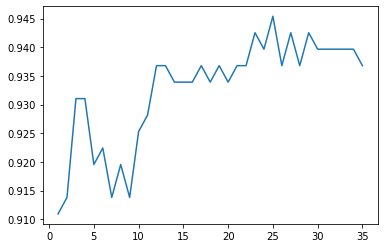

In [99]:
plt.plot(range(1, 36), scores)  # set k=25

In [100]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

Test Accuracy score:  0.9454022988505747
Test F1 score:  0.9422492401215805


array([[174,  10],
       [  9, 155]], dtype=int64)

## AdaBoost

In [103]:
ada_class = AdaBoostClassifier(random_state = 12)
ada_class.fit(X_train, y_train)
print(ada_class.score(X_train, y_train))
print(ada_class.score(X_test, y_test))

0.9209770114942529
0.9195402298850575


## XGBoost

In [105]:
xgb_class = XGBClassifier(random_state = 12)
xgb_rf_class = XGBRFClassifier(random_state = 12)
xgb_class.fit(X_train, y_train)
print(xgb_class.score(X_train, y_train))
print(xgb_class.score(X_test, y_test))

xgb_rf_class.fit(X_train, y_train)
print(xgb_rf_class.score(X_train, y_train))
print(xgb_rf_class.score(X_test, y_test))

0.9626436781609196
0.9482758620689655
0.9461206896551724
0.9511494252873564


## Testing (Omer's ideas)

In [ ]:
(housevotes_df.dem_L2_wins - housevotes_df.dem_L1_wins).

In [ ]:
test_flips_df = housevotes_df[(housevotes_df.target - housevotes_df.dem_L1_wins) != 0]  # flips in either direction
test_flips_df.shape

In [ ]:
(housevotes_df.target - housevotes_df.dem_L1_wins).value_counts()

In [ ]:
test_flips_df.groupby(['dem_L1_wins', 'dem_L2_wins']).size()

In [ ]:
housevotes_df.dem_L2_wins.value_counts()

In [ ]:
test_df = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_prob[:, 1]), y_test.reset_index(drop=True)], axis=1)
test_df = test_df.rename(columns={0:'predicted_proba'})
test_df.loc[(test_df.swing_district == 1) & (test_df.incumbent_in_race == 0), ['dL1_winner', 
                                                                               'dL1_winner', 
                                                                               'incumbent_L3_races', 
                                                                               'incumbent_in_race', 
#                                                                                'swing_district', 
                                                                               'predicted_proba', 
                                                                               'target']]#.shape

Heatmap to visualize correlations

In [74]:
# housevotes_df[features_model_1].corr()[['target']]

In [75]:
# plt.figure(figsize = (20,16))
# sns.heatmap(housevotes_df[features_model_1].corr(), center=0, annot = True)

## To do:

- Try MERF, logistic, knn
- baseline model: always predict what it was before (using just 1 lag term)
- check all columns are supposed to be there
- dig into exact observations where it changed to 1 in 2018, what is driving the prediction there
- build a model with swing states (the 60) matched on 60 non-swings, try with other estimators too (logistic, SVM, etc.)

Later:
- grid search for hyperparameter tuning
- k-folds cross validataion